## Machine Learning - Desafío 1, Regularización
#### Gustavo Morales, G10 - 18.Nov.2019, (Lunes Semana 1)

### Ejercicio 1: Preparación del Ambiente de Trabajo

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
import seaborn as sns
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
plt.style.use('seaborn-notebook')
%matplotlib inline

In [2]:
fname = 'winequality-red.csv'

In [3]:
df = pd.read_csv(fname)

In [4]:
df.sample(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
605            8.3              0.60         0.13             2.6      0.085   
566            8.7              0.70         0.24             2.5      0.226   
863            7.2              0.62         0.06             2.5      0.078   
996            5.6              0.66         0.00             2.2      0.087   
424            7.7              0.96         0.20             2.0      0.047   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
605                  6.0                  24.0  0.99840  3.31       0.59   
566                  5.0                  15.0  0.99910  3.32       0.60   
863                 17.0                  84.0  0.99746  3.51       0.53   
996                  3.0                  11.0  0.99378  3.71       0.63   
424                 15.0                  60.0  0.99550  3.36       0.44   

     alcohol  quality  
605      9.2        6  
566      9.0        6  
863      9.7        5  
996     12.8        7  
424     10.9        5

### Ejercicio 2: Análisis exploratorio

**(R)** Los tipos de datos son:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


**(R)** Outliers univariados:

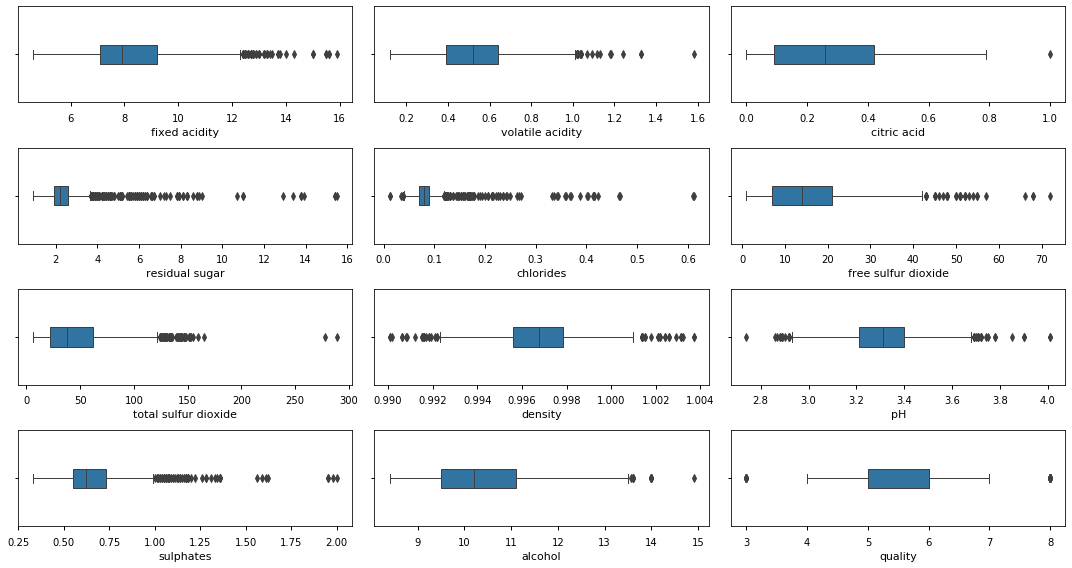

In [6]:
plt.rcParams['figure.figsize'] = 15, 8
var_lst = df.columns.tolist()
for i, var in enumerate(var_lst):
    plt.subplot(4,3,i+1)
    sns.boxplot(x=df[var], width=0.2, color=None, linewidth=1.0)
plt.tight_layout()

**(R)** Outliers multivariados e histogramas:

In [7]:
axs = pd.plotting.scatter_matrix(df, alpha=0.2, diagonal='hist')
for x in range(len(df.columns)):
    for y in range(len(df.columns)):
        ax = axs[x, y]  # to get the axis of subplots
        ax.xaxis.label.set_rotation(90)  # to make x axis name vertical
        ax.yaxis.label.set_rotation(0)  # to make y axis name horizontal 
        ax.yaxis.labelpad = 75  # to make sure y axis names are outside the plot area
plt.tight_layout()

Lo haré de otra forma:

In [8]:
from scipy.stats import pearsonr
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top right hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    # rho = '\u03C1'
    ax.annotate(f'{r:.2f}', xy=(.85, .9), xycoords=ax.transAxes, fontsize=14)

In [9]:
def plot_pair_grid(dataframe, variables=None):
    grid = sns.PairGrid(data=dataframe, vars=variables, dropna=True)
    grid = grid.map_upper(sns.regplot, color='black', scatter_kws={'alpha': 0.1})
    grid = grid.map_upper(corrfunc)
    grid = grid.map_lower(sns.kdeplot, cmap='binary')
    grid = grid.map_diag(sns.distplot, kde=False, rug=True, color='black')
    plt.tight_layout()

In [10]:
vars1 = ['fixed acidity',
        'volatile acidity',
        'citric acid',
        'residual sugar']
vars2 = ['chlorides',
        'free sulfur dioxide',
        'total sulfur dioxide',
        'density']
vars3 = ['pH',
        'sulphates',
        'alcohol',
        'quality']

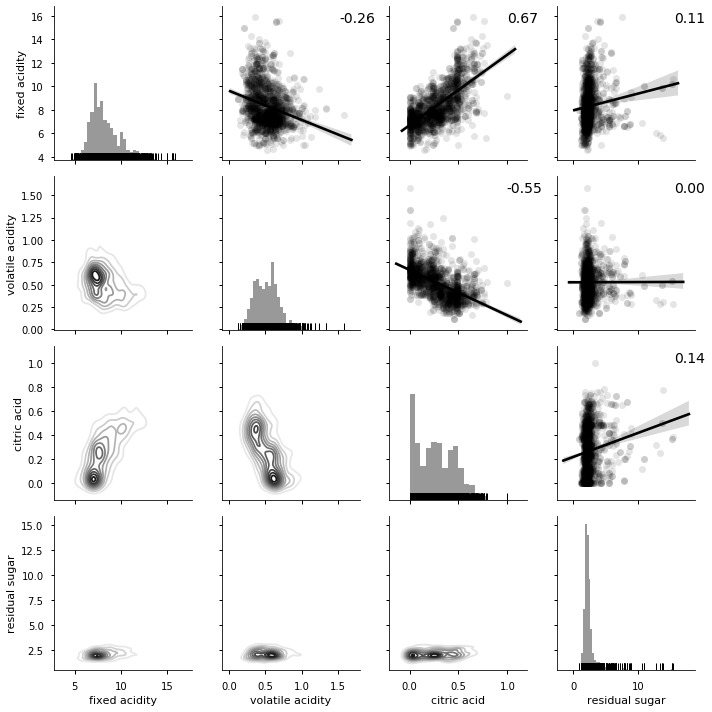

In [11]:
plot_pair_grid(df, variables=vars1)

In [12]:
plot_pair_grid(df, variables=vars2)

In [13]:
plot_pair_grid(df, variables=vars3)

**(R)** Cantidad de valores faltantes en cada columna:

In [14]:
df.isnull().sum(axis = 0)  # NaN distribution columnwise

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

**(R)** Distribución empírica de cada atributo:

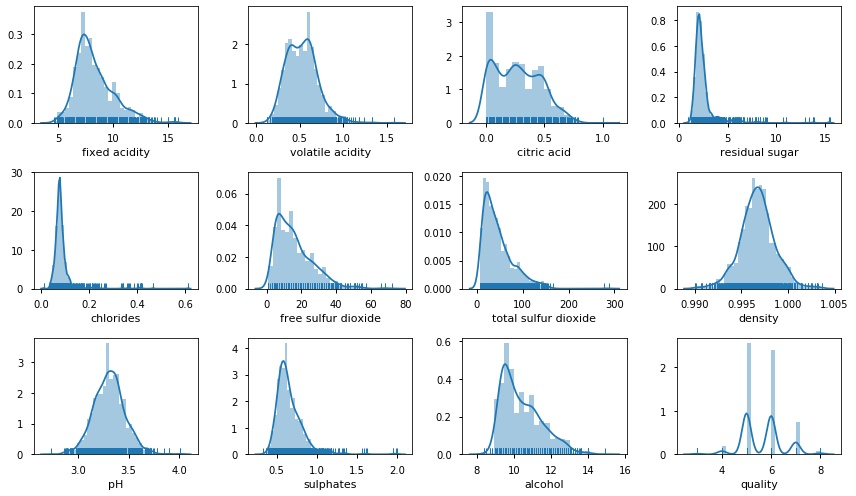

In [15]:
plt.rcParams['figure.figsize'] = 12, 7
for i, var in enumerate(var_lst):
    plt.subplot(3,4,i+1)
    sns.distplot(df[var], rug=True)
plt.tight_layout()

### Ejercicio 3: Regularización de modelos

In [16]:
X = df.drop(['quality'], axis=1)  # features
y = df['quality']  # target
ALPHAS_RIDGE = np.logspace(0, 7, base = 10)
ALPHAS_LASSO = np.logspace(0, -3, base = 10)
ALPHAS_ELNET = np.logspace(0, -3, base = 10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 63)

In [17]:
CVAL = 10
ridge = RidgeCV(alphas=ALPHAS_RIDGE, cv=CVAL).fit(X_train, y_train)
lasso = LassoCV(alphas=ALPHAS_LASSO, cv=CVAL).fit(X_train, y_train)
elnet = ElasticNetCV(alphas=ALPHAS_ELNET, cv=CVAL).fit(X_train, y_train)

**(R)** Coeficientes estimados:

In [18]:
coefs_df = pd.DataFrame(data={'RidgeCV': ridge.coef_.tolist(),
                              'LassoCV': lasso.coef_.tolist(),
                              'ElasticNetCV': elnet.coef_.tolist()},
                        index=X.columns.tolist()).transpose()

**(R)** Mejores $\alpha$:

In [19]:
alpha_ridge = ridge.alpha_
alpha_lasso = lasso.alpha_
alpha_elnet = elnet.alpha_
best_alphas = [alpha_ridge, alpha_lasso, alpha_elnet]

**(R)** RMSE y MAE:

In [20]:
rmse_ridge = np.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))
rmse_elnet = np.sqrt(mean_squared_error(y_test, elnet.predict(X_test)))
mae_ridge = median_absolute_error(y_test, ridge.predict(X_test))
mae_lasso = median_absolute_error(y_test, lasso.predict(X_test))
mae_elnet = median_absolute_error(y_test, elnet.predict(X_test))
rmses = [rmse_ridge, rmse_lasso, rmse_elnet]
maes = [mae_ridge, mae_lasso, mae_elnet]

In [21]:
pd.DataFrame(data={'Best alphas': best_alphas,
                   'RMSE': rmses,
                   'MAE:': maes},
             index=['RidgeCV', 'Lasso', 'ElasticNet'])

Best alphas      RMSE      MAE:
RidgeCV           1.000  0.641679  0.384386
Lasso             0.001  0.643180  0.390534
ElasticNet        0.001  0.642083  0.383964

**(R)** ¿Qué modelo presenta un mejor desempeño en base a las métricas?\
Todos los modelos presentan un desempeño similar basado en estas métricas.

**(R)** ¿Qué atributos mantienen un comportamiento similar a lo largo de cada modelo?

La tabla de coeficientes es la siguiente:

In [22]:
coefs_df

fixed acidity  volatile acidity  citric acid  residual sugar  \
RidgeCV            0.006089         -1.121102    -0.200895        0.016479   
LassoCV            0.000233         -1.066347    -0.084356        0.016011   
ElasticNetCV       0.003996         -1.099357    -0.151063        0.016125   

              chlorides  free sulfur dioxide  total sulfur dioxide   density  \
RidgeCV       -1.694864             0.004791             -0.003732 -0.021033   
LassoCV       -2.080768             0.005028             -0.003885 -0.000000   
ElasticNetCV  -1.813673             0.004886             -0.003789 -0.000000   

                    pH  sulphates   alcohol  
RidgeCV      -0.485734   0.771286  0.290933  
LassoCV      -0.461436   0.796035  0.283820  
ElasticNetCV -0.468045   0.775526  0.288218

Una métrica que puedo usar para medir que tan distintos son los coeficientes a lo largo de cada modelo es la desviación estándar de cada trío de valores:

In [23]:
coefs_df.std().sort_values()

total sulfur dioxide    0.000077
free sulfur dioxide     0.000119
residual sugar          0.000244
fixed acidity           0.002967
alcohol                 0.003590
density                 0.012143
pH                      0.012563
sulphates               0.013236
volatile acidity        0.027570
citric acid             0.058473
chlorides               0.197644
dtype: float64

Es decir, `total sulfur dioxide`, `free sulfur dioxide` y `residual sugar` son mis tres coeficientes con menos dispersión a lo largo de cada modelo.

Bonus: coeficientes de regresión en función del parámetro de regularización, para cada modelo.

In [24]:
def plot_behavior(model_name, train_data, alpha_values):
    plt.rcParams['figure.figsize'] = 10, 7
    coefs_model, cv_err_model = [], []
    if model_name == 'ridge':
        model = Ridge(fit_intercept=True)
    if model_name == 'lasso':
        model = Lasso(fit_intercept=True)
    if model_name == 'elnet':
        model = ElasticNet(fit_intercept=True)
    
    for alpha in alpha_values:
        model.set_params(alpha=alpha)
        model.fit(train_data[0], train_data[1])
        coefs_model.append(model.coef_)
    
    ax = plt.gca()
    for y_arr, label in zip(np.squeeze(coefs_model).T, train_data[0].columns):
        plt.plot(alpha_values, y_arr, label=label)
    
    ax.set_xscale('log')
    plt.title(model_name)
    plt.xlabel('Lambda')
    plt.ylabel('Coeficiente de regresión')
    plt.legend()
    plt.tight_layout()

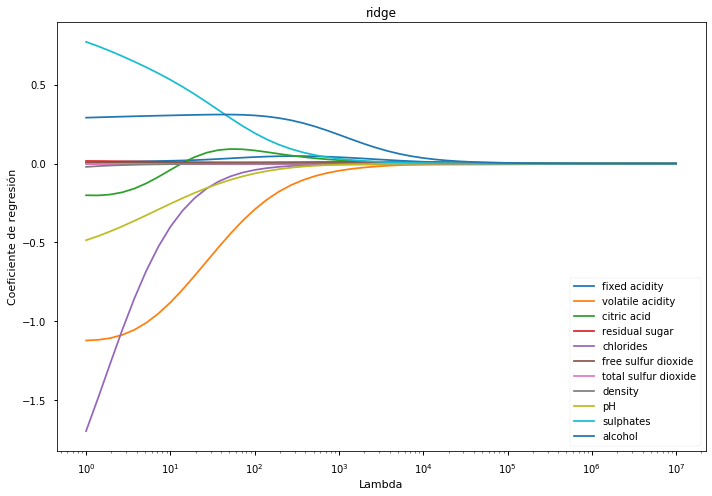

In [25]:
plot_behavior(model_name='ridge', train_data=[X_train, y_train], alpha_values=ALPHAS_RIDGE)

In [26]:
plot_behavior(model_name='lasso', train_data=[X_train, y_train], alpha_values=ALPHAS_LASSO)

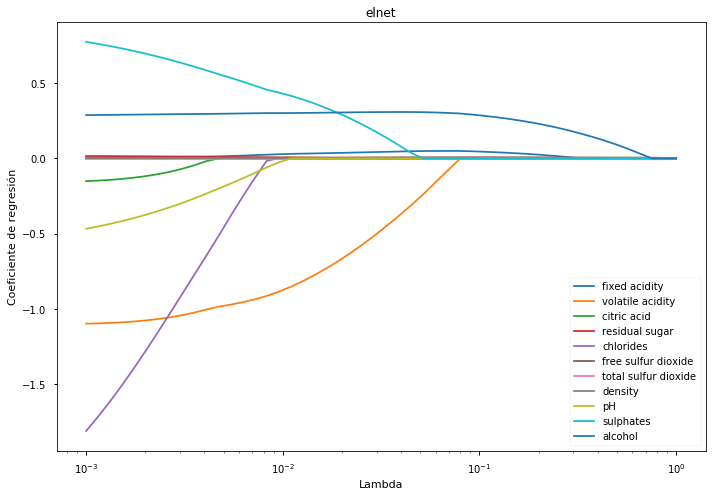

In [27]:
plot_behavior(model_name='elnet', train_data=[X_train, y_train], alpha_values=ALPHAS_ELNET)